# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


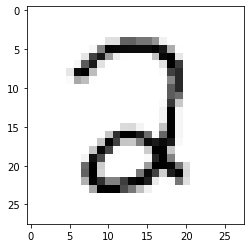

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2409
Training Accuracy: 0.6794, Testing Accuracy: 0.6971



Epoch 10, Loss 0.0825
Training Accuracy: 0.9202, Testing Accuracy: 0.9289



Epoch 20, Loss 0.0528
Training Accuracy: 0.9440, Testing Accuracy: 0.9521



Epoch 30, Loss 0.0424
Training Accuracy: 0.9528, Testing Accuracy: 0.9607



Epoch 40, Loss 0.0372
Training Accuracy: 0.9566, Testing Accuracy: 0.9637



Epoch 50, Loss 0.0341
Training Accuracy: 0.9599, Testing Accuracy: 0.9652



Epoch 60, Loss 0.032
Training Accuracy: 0.9622, Testing Accuracy: 0.9657



Epoch 70, Loss 0.0304
Training Accuracy: 0.9635, Testing Accuracy: 0.9672



Epoch 80, Loss 0.029
Training Accuracy: 0.9649, Testing Accuracy: 0.9682



Epoch 90, Loss 0.0279
Training Accuracy: 0.9662, Testing Accuracy: 0.9677



Epoch 100, Loss 0.0269
Training Accuracy: 0.9670, Testing Accuracy: 0.9677



Epoch 110, Loss 0.0261
Training Accuracy: 0.9686, Testing Accuracy: 0.9677



Epoch 120, Loss 0.0253
Training Accuracy: 0.9700, Testing Accuracy: 0.9667



Epoch 130, Loss 0.0246
Training Accuracy: 0.9707, Testing Accuracy: 0.9672



Epoch 140, Loss 0.024
Training Accuracy: 0.9715, Testing Accuracy: 0.9682



Epoch 150, Loss 0.0234
Training Accuracy: 0.9719, Testing Accuracy: 0.9682



Epoch 160, Loss 0.0229
Training Accuracy: 0.9726, Testing Accuracy: 0.9688



Epoch 170, Loss 0.0224
Training Accuracy: 0.9736, Testing Accuracy: 0.9688



Epoch 180, Loss 0.0219
Training Accuracy: 0.9747, Testing Accuracy: 0.9682



Epoch 190, Loss 0.0214
Training Accuracy: 0.9752, Testing Accuracy: 0.9688



Epoch 200, Loss 0.021
Training Accuracy: 0.9760, Testing Accuracy: 0.9693



Epoch 210, Loss 0.0206
Training Accuracy: 0.9765, Testing Accuracy: 0.9693



Epoch 220, Loss 0.0202
Training Accuracy: 0.9770, Testing Accuracy: 0.9698



Epoch 230, Loss 0.0198
Training Accuracy: 0.9777, Testing Accuracy: 0.9703



Epoch 240, Loss 0.0195
Training Accuracy: 0.9781, Testing Accuracy: 0.9708



0.010217677689499011

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2233
Training Accuracy: 0.7480, Testing Accuracy: 0.7928



Epoch 10, Loss 0.0998
Training Accuracy: 0.9128, Testing Accuracy: 0.9234



Epoch 20, Loss 0.0779
Training Accuracy: 0.9293, Testing Accuracy: 0.9375



Epoch 30, Loss 0.0677
Training Accuracy: 0.9361, Testing Accuracy: 0.9446



Epoch 40, Loss 0.0615
Training Accuracy: 0.9402, Testing Accuracy: 0.9486



Epoch 50, Loss 0.0572
Training Accuracy: 0.9429, Testing Accuracy: 0.9536



Epoch 60, Loss 0.054
Training Accuracy: 0.9453, Testing Accuracy: 0.9567



Epoch 70, Loss 0.0516
Training Accuracy: 0.9473, Testing Accuracy: 0.9572



Epoch 80, Loss 0.0496
Training Accuracy: 0.9493, Testing Accuracy: 0.9582



Epoch 90, Loss 0.0479
Training Accuracy: 0.9510, Testing Accuracy: 0.9617



Epoch 100, Loss 0.0465
Training Accuracy: 0.9521, Testing Accuracy: 0.9642



Epoch 110, Loss 0.0453
Training Accuracy: 0.9532, Testing Accuracy: 0.9642



Epoch 120, Loss 0.0443
Training Accuracy: 0.9542, Testing Accuracy: 0.9642



Epoch 130, Loss 0.0433
Training Accuracy: 0.9548, Testing Accuracy: 0.9642



Epoch 140, Loss 0.0425
Training Accuracy: 0.9555, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0417
Training Accuracy: 0.9559, Testing Accuracy: 0.9642



Epoch 160, Loss 0.0411
Training Accuracy: 0.9563, Testing Accuracy: 0.9642



Epoch 170, Loss 0.0405
Training Accuracy: 0.9570, Testing Accuracy: 0.9647



Epoch 180, Loss 0.0399
Training Accuracy: 0.9577, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0394
Training Accuracy: 0.9580, Testing Accuracy: 0.9652



Epoch 200, Loss 0.0389
Training Accuracy: 0.9582, Testing Accuracy: 0.9662



Epoch 210, Loss 0.0384
Training Accuracy: 0.9586, Testing Accuracy: 0.9662



Epoch 220, Loss 0.038
Training Accuracy: 0.9589, Testing Accuracy: 0.9662



Epoch 230, Loss 0.0376
Training Accuracy: 0.9590, Testing Accuracy: 0.9657



Epoch 240, Loss 0.0372
Training Accuracy: 0.9591, Testing Accuracy: 0.9662



0.0415303690572429

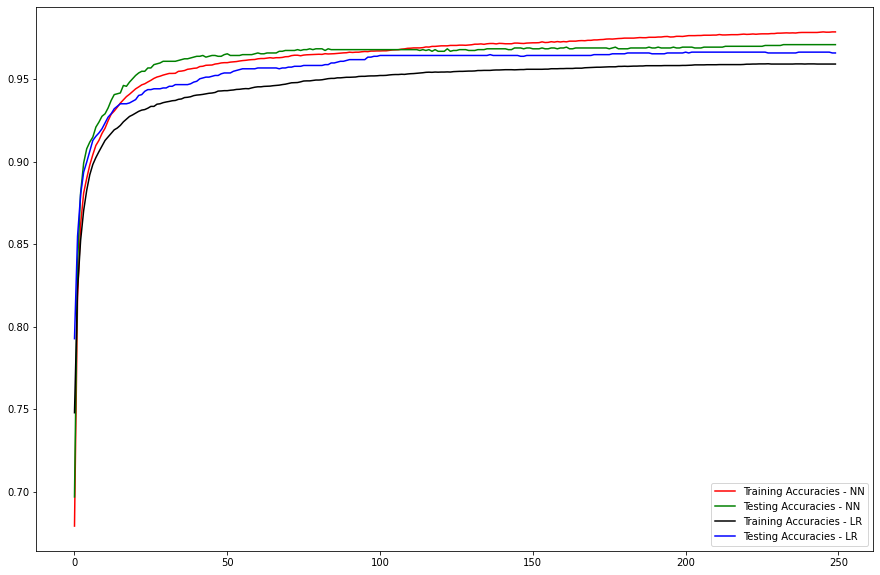

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

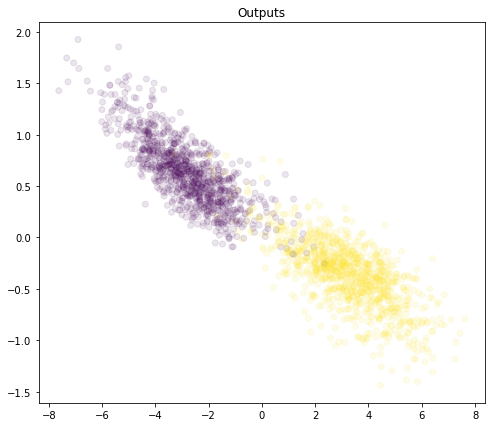

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

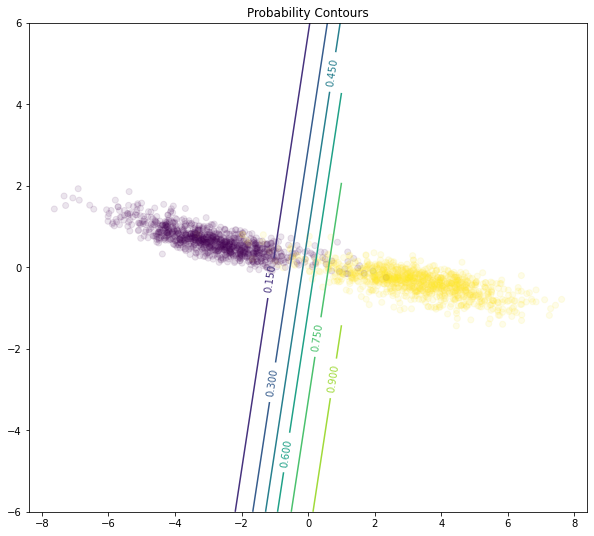

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );